# Imports

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from bresenham import bresenham
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import median
from datetime import datetime 
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
from pydicom._storage_sopclass_uids import MRImageStorage
import ipywidgets as widgets

# Global variables

In [196]:
STEP = 1 # step of emitter in degrees
NUMBER_OF_DETECTORS = 90
DETECTORS_RANGE = 90 # degrees
RANGE = 360 # iterations
RADIUS = int() # initialized and compute after image is loaded
IS_FILTER = True
IS_DICOM = True
SOURCE = "photos/Kwadraty2.jpg"

PATIENT_NAME = "Karol Okrasa"
DESCRIPTION = "description"
DATE = datetime.now()

# Main

In [197]:
def main():
    image = rgb2gray(imread(SOURCE))
    resized = resize(image, (len(image) / 4, len(image[0]) / 4))
    new_edge = round(math.sqrt(2) * max(len(resized), len(resized[0])))
    radius = round(new_edge / 2)

    image = np.zeros([new_edge, new_edge])
    image[radius - round(len(resized) / 2) : radius + round(len(resized) / 2), radius - round(len(resized[0]) / 2) : radius + round(len(resized[0]) / 2)] = resized

    global RADIUS     
    RADIUS = round(len(image) / 2) - 1

    display_image(image, "Zdjęcie wejściowe")
    
    sinogram = make_sinogram(image)
    normalized_sinogram = normalize(sinogram)
    display_image(normalized_sinogram, "Sinogram")
    
    reverse_sinogram = make_reverse_sinogram(sinogram, [len(image), len(image[0])])
    reverse_sinogram = reverse_sinogram[round(len(image) / 4) : 3 * round(len(image) / 4), round(len(image[0]) / 4) : 3 * round(len(image[0]) / 4)]
    normalized_reverse_sinogram = normalize(reverse_sinogram)
    display_image(reverse_sinogram, "Reverse Sinogram")

    if IS_FILTER:
        filtered_normalized_reverse_sinogram = median(normalized_reverse_sinogram, selem=np.ones((5, 5)))
        display_image(filtered_normalized_reverse_sinogram, "Filtered Reverse Sinogram")

    if IS_DICOM:
        create_dicom(filtered_normalized_reverse_sinogram)
        dicom_image = pydicom.dcmread("output.dcm")
        display_image(dicom_image.pixel_array, "DICOM")

# Functions

### Display Image

In [198]:
def display_image(image, title):
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

### Emiter position

In [199]:
def set_emitter_position(angle):
    x = RADIUS * math.cos(math.radians(angle)) + RADIUS
    y = RADIUS * math.sin(math.radians(angle)) + RADIUS
    return [round(x), round(y)]

### Detectors positions

In [200]:
def set_detectors_positions(angle):
    result = list()
    
    for i in range(NUMBER_OF_DETECTORS):
        x = RADIUS * math.cos(math.radians(angle) + math.pi - (math.radians(DETECTORS_RANGE) / 2) 
                         + i * (math.radians(DETECTORS_RANGE) / (NUMBER_OF_DETECTORS - 1)))
        y = RADIUS * math.sin(math.radians(angle) + math.pi - (math.radians(DETECTORS_RANGE) / 2) 
                         + i * (math.radians(DETECTORS_RANGE) / (NUMBER_OF_DETECTORS - 1)))
        result.append([round(x + RADIUS), round(y + RADIUS)])
    
    return result

### All positions

In [201]:
def set_positions():
    emitters = list()
    detectors = list()
    
    for i in range (0, RANGE, STEP):
        emitters.append(set_emitter_position(i))
        detectors.append(set_detectors_positions(i))
        
    return emitters, detectors

### Sinogram

In [202]:
def make_sinogram(image):
    emitters, detectors = set_positions()
    sinogram = np.zeros([len(emitters), len(detectors[0])])
    
    for i, [emitterX, emitterY] in enumerate(emitters):
        for j, [detectorX, detectorY] in enumerate(detectors[i]):
            line = bresenham(emitterX, emitterY, detectorX, detectorY)

            for x, y in line:
                sinogram[i, j] += image[x, y]
            
    return sinogram 

### Reverse Sinogram

In [203]:
def make_reverse_sinogram(image, dimensions):
    emitters, detectors = set_positions()
    reverse_sinogram = np.zeros(dimensions)
    
    for i, [emitterX, emitterY] in enumerate(emitters):
        for j, [detectorX, detectorY] in enumerate(detectors[i]):
            line = bresenham(emitterX, emitterY, detectorX, detectorY)
            
            for x, y in line:
                reverse_sinogram[x, y] += image[i][j]
                
    return reverse_sinogram

### Normalize

In [204]:
def normalize(image):
    min_value = np.min(image)
    max_value = np.max(image)

    for i in range(len(image)):
        for j in range(len(image[i])):
            image[i, j] = (image[i, j] - min_value) / (max_value - min_value) 

    return image

# DICOM

In [205]:
def create_dicom(image):
    image *= 256
    image = image.astype(np.uint16)

    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
    file_meta.MediaStorageSOPInstanceUID = "1.2.3"
    file_meta.ImplementationClassUID = "1.2.3.4"
    file_meta.TransferSyntaxUID = ExplicitVRLittleEndian

    ds = FileDataset("output.dcm", {}, file_meta=file_meta, preamble=b"\0" * 128)
    ds.is_little_endian = True
    ds.is_implicit_VR = False
    ds.PatientName = PATIENT_NAME
    ds.ContentDate = DATE.strftime('%Y%m%d')
    ds.ContentTime = DATE.strftime('%H%M%S.%f')
    ds.StudyDescription = DESCRIPTION
    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.PixelRepresentation = 1
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.HighBit = 15
    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SmallestImagePixelValue = str.encode('\x00\x00')
    ds.LargestImagePixelValue = str.encode('\xff\xff')
    ds.SOPClassUID = MRImageStorage
    ds.Columns = len(image)
    ds.Rows = len(image[0])

    ds.PixelData = image.tobytes()

    ds.save_as("output.dcm")

# GUI

In [212]:
sliders = []
sliders.append(widgets.IntSlider(description = "Range", min=10, max=360, step=10, value=360)) # iterations - whole cirlce
sliders.append(widgets.IntSlider(description = "Step in degrees", min=1, max=36, step=1, value=1)) # step of emitter in degrees
sliders.append(widgets.IntSlider(description = "Number of Detectors", min=10, max=300, step=5, value=90))
sliders.append(widgets.IntSlider(description="Detectors range", min=0, max=360, step=10, value=90)) # degrees

def on_change_RANGE(v):
    global RANGE
    RANGE = v['new']

def on_change_STEP(v):
    global STEP
    STEP = v['new']
    
def on_change_NUMBER_OF_DETECTORS(v):
    global NUMBER_OF_DETECTORS
    NUMBER_OF_DETECTORS = v['new']
    
def on_change_DETECTORS_RANGE(v):
    global DETECTORS_RANGE
    DETECTORS_RANGE = v['new']

sliders[0].observe(on_change_RANGE, names="value")
sliders[1].observe(on_change_STEP, names="value")
sliders[2].observe(on_change_NUMBER_OF_DETECTORS, names="value")
sliders[3].observe(on_change_DETECTORS_RANGE, names="value")

for slider in sliders:
    hbox=widgets.HBox([widgets.Label(slider.description),slider])
    slider.description=""
    display(hbox)

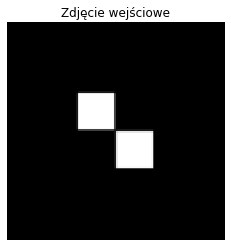

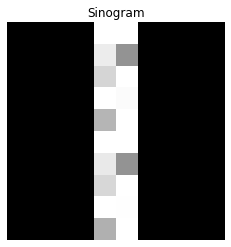

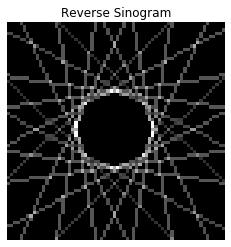

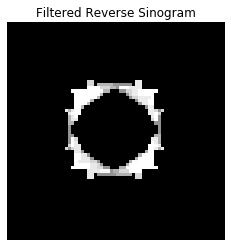

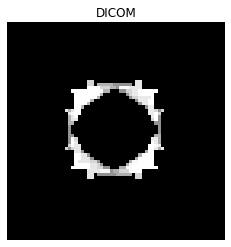

In [222]:
main()